# Fairness Evaluation of SVD++ on the MovieLens 100K Dataset

**Course:** System Development for Marketing  
**Assignment:** Hyperpersonalization – Recommender Systems  
**Model Focus:** SVD++  
**Dataset:** MovieLens 100K  
**Author:** Lucas van der Wielen  
**Date:** 04-04-2025

## Introduction

This notebook presents the implementation and evaluation of the SVD++ algorithm on the MovieLens 100K dataset. SVD++ is a matrix factorization-based collaborative filtering model that incorporates both explicit ratings and implicit feedback to improve recommendation accuracy.

The objective of this notebook is:

1. **Model Implementation and Evaluation**: Build and assess the predictive performance of SVD++ using RMSE.
2. **Prepare a Dataset for Fairness Evaluation**: Create a general dataset to use for fairness evaluation across the different models

To enable a meaningful comparison across datasets (such as MovieLens and Yelp), gender is selected as the primary sensitive attribute, as age data is not consistently available across all datasets. Throughout this notebook, we follow a reproducible pipeline that includes data preprocessing, model training, prediction, and evaluation using both accuracy-based and fairness-based metrics.

## Datasets needed for this Jupyter Notebook:

- `df_full.csv`  
  Preprocessed dataset combining ratings and user/item metadata.

### Importing Libraries and Packages
In this section, we import the necessary libraries and packages that will be used throughout the code for data manipulation, model building, and evaluation.

In [22]:
# Import necessary libraries
import pandas as pd #pandas and numpy are imported for data manipulation and numerical operations.
import numpy as np
from surprise import SVDpp, Dataset, Reader, accuracy #SVDpp, Dataset, Reader, and accuracy are from the Surprise library, used for building and evaluating the SVD++ model.
from surprise.model_selection import train_test_split # train_test_split is used to split the data into training and testing sets.
from itertools import product # itertools.product is useful for creating combinations of hyperparameters for grid search.
import time # time is used to track the execution time of model training.
import matplotlib.pyplot as plt # used to plot visualizations
import seaborn as sns #

In [23]:
# Define the path to your CSV file
file_path = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\df_full.csv"

# Load the CSV file into a DataFrame
df_full = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to check
print(df_full.head())
print(df_full.shape)

   movie_id  user_id  rating            timestamp  age gender  occupation  \
0       242      196       3  1997-12-04 15:55:49   49      M      writer   
1       302      186       3  1998-04-04 19:22:22   39      F   executive   
2       377       22       1  1997-11-07 07:18:36   25      M      writer   
3        51      244       2  1997-11-27 05:02:03   28      M  technician   
4       346      166       1  1998-02-02 05:33:16   47      M    educator   

  zip_code                       title release_date  release_year  
0    55105                Kolya (1996)  24-Jan-1997          1997  
1    00000    L.A. Confidential (1997)  01-Jan-1997          1997  
2    40206         Heavyweights (1994)  01-Jan-1994          1994  
3    80525  Legends of the Fall (1994)  01-Jan-1994          1994  
4    55113         Jackie Brown (1997)  01-Jan-1997          1997  
(99991, 11)


In [24]:
# Create the user-item matrix with your specific DataFrame (df_full)
user_item_matrix = df_full.pivot_table(
    index='user_id',       # Set 'user_id' as rows
    columns='movie_id',    # Set 'movie_id' as columns
    values='rating',       # Use 'rating' as values

)
# Check the shape of the resulting matrix and display the first few rows
print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
user_item_matrix

User-Item Matrix Shape: (943, 1681)


movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Create empty train/test matrices with same shape and NaNs
train_matrix = user_item_matrix.copy() * np.nan
test_matrix = user_item_matrix.copy() * np.nan

In [26]:
# Split each user's ratings into training and testing
for user_id in user_item_matrix.index:
    user_ratings = user_item_matrix.loc[user_id]
    rated_items = user_ratings.dropna()  # Keep only the non-null ratings for this user

    # Random shuffle the rated items
    shuffled = rated_items.sample(frac=1, random_state=42)

    # Split into 80% train and 20% test
    cutoff = int(0.8 * len(shuffled))  # 80% for training
    train_items = shuffled.iloc[:cutoff]
    test_items = shuffled.iloc[cutoff:]

    # Assign ratings back to correct movie columns (ensure we are assigning the correct movie ID indices)
    train_matrix.loc[user_id, train_items.index] = train_items.values
    test_matrix.loc[user_id, test_items.index] = test_items.values

# Check the shape of the train and test matrices
print("Train Matrix Shape:", train_matrix.shape)
print("Test Matrix Shape:", test_matrix.shape)

# Optional: Check the first few rows of the train and test matrices
print("Train Matrix Sample:")
print(train_matrix.head())

print("Test Matrix Sample:")
print(test_matrix.head())


Train Matrix Shape: (943, 1681)
Test Matrix Shape: (943, 1681)
Train Matrix Sample:
movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   NaN   3.0  ...   
2          4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5          4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

movie_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                               
1          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4          NaN   NaN 

In [27]:
# Double checks
# Total number of ratings check
original_count = (~user_item_matrix.isna()).sum().sum()
train_count = (~train_matrix.isna()).sum().sum()
test_count = (~test_matrix.isna()).sum().sum()

print(f"Original rating count: {original_count}")
print(f"Train rating count:    {train_count}")
print(f"Test rating count:     {test_count}")
print(f"Total (train + test):  {train_count + test_count}")
print("Rating count preserved:", original_count == train_count + test_count)

# Overlap check
overlap = (~train_matrix.isna()) & (~test_matrix.isna())
overlap_count = overlap.sum().sum()
print(f"Overlapping ratings in train and test: {overlap_count}")  # Should be 0
print("No overlap between train and test:", overlap_count == 0)

Original rating count: 99991
Train rating count:    79610
Test rating count:     20381
Total (train + test):  99991
Rating count preserved: True
Overlapping ratings in train and test: 0
No overlap between train and test: True


In [28]:
# Convert to long format for SVD++/Surprise ---
train_long = train_matrix.stack().reset_index()
train_long.columns = ['userid', 'movieid', 'rating']

test_long = test_matrix.stack().reset_index()
test_long.columns = ['userid', 'movieid', 'rating']

In [29]:
train_long

,userid,movieid,rating
0,1,1,5.0
1,1,2,3.0
2,1,3,4.0
3,1,4,3.0
4,1,5,3.0
...,...,...,...
79605,943,1028,2.0
79606,943,1044,3.0
79607,943,1067,2.0
79608,943,1074,4.0


In [30]:
test_long

,userid,movieid,rating
0,1,9,5.0
1,1,14,5.0
2,1,15,5.0
3,1,18,4.0
4,1,21,1.0
...,...,...,...
20376,943,825,3.0
20377,943,943,5.0
20378,943,1047,2.0
20379,943,1188,3.0


In this notebook, the `surprise` library is used specifically to implement and evaluate the SVD++ model. `surprise` is a Python library built for collaborative filtering tasks and includes efficient implementations of algorithms such as SVD, SVD++, and KNN.

We use `surprise` for SVD++ because:

- It provides a reliable and optimized implementation of the algorithm, including support for implicit feedback.
- It offers convenient tools for data preparation, model training, and evaluation, such as `Dataset`, `Reader`, `train_test_split`, and `accuracy.rmse`.
- It handles internal indexing of user and item IDs and manages matrix operations in a memory-efficient format.

The `SVDpp` class in `surprise` extends standard matrix factorization by including implicit signals (e.g., which items users interacted with), leading to more accurate predictions in recommendation systems with sparse data like MovieLens 100K.

Since our focus in this notebook is to assess both the accuracy and fairness of SVD++, `surprise` enables a clean and practical way to build the model without implementing the full optimization logic manually.


In [31]:
# Create reader and load train data 
reader = Reader(rating_scale=(1, 5))
train_data_dataset = Dataset.load_from_df(train_long[['userid', 'movieid', 'rating']], reader)

# Build the full trainset from your custom training data
full_trainset = train_data_dataset.build_full_trainset()

In [32]:
# Use test_long as your custom test set
# Surprise needs testset in format: [(uid, iid, true_rating)]
custom_testset = list(test_long.itertuples(index=False, name=None))  # ('userid', 'movieid', 'rating')

In [33]:
# Split training into smaller train/validation set for tuning ---
# Re-wrap full trainset into DataFrame
train_df_for_tuning = pd.DataFrame(full_trainset.build_testset(), columns=['userid', 'movieid', 'rating'])

# Load it into a new dataset and split it for tuning
tuning_data = Dataset.load_from_df(train_df_for_tuning, reader)
smaller_trainset, validation_set = train_test_split(tuning_data, test_size=0.2, random_state=42)

In [34]:
# Grid Search over SVD++ parameters
param_grid = {
    'n_factors': [10, 20, 30],
    'n_epochs': [5, 10, 20],
    'lr_all': [0.005, 0.007],
    'reg_all': [0.1]
}

best_rmse = float('inf')
best_params = None

# Get total combinations for progress logging
keys, values = zip(*param_grid.items())
total_combinations = len(list(product(*values)))
combo_count = 1

print(f"Starting grid search over {total_combinations} combinations...\n")

for combo in product(*values):
    params = dict(zip(keys, combo))
    print(f"[{combo_count}/{total_combinations}] Training with params: {params}")
    start_time = time.time()

    # Train model
    model = SVDpp(**params, random_state=42, verbose=False)
    model.fit(smaller_trainset)

    # Predict on validation set
    predictions = model.test(validation_set)
    rmse = accuracy.rmse(predictions, verbose=False)

    elapsed = time.time() - start_time
    print(f"Completed in {elapsed:.2f} seconds — RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        print(f"New best RMSE, (was {best_rmse:.4f})")
        best_rmse = rmse
        best_params = params

    print("-" * 50)
    combo_count += 1

print(f"\nGrid search complete. Best RMSE: {best_rmse:.4f}")
print(f"Best parameters: {best_params}")

Starting grid search over 18 combinations...

[1/18] Training with params: {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.1}
Completed in 3.33 seconds — RMSE: 0.9555
New best RMSE, (was inf)
--------------------------------------------------
[2/18] Training with params: {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.007, 'reg_all': 0.1}
Completed in 3.77 seconds — RMSE: 0.9498
New best RMSE, (was 0.9555)
--------------------------------------------------
[3/18] Training with params: {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.1}
Completed in 4.49 seconds — RMSE: 0.9450
New best RMSE, (was 0.9498)
--------------------------------------------------
[4/18] Training with params: {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.007, 'reg_all': 0.1}
Completed in 4.47 seconds — RMSE: 0.9420
New best RMSE, (was 0.9450)
--------------------------------------------------
[5/18] Training with params: {'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}

Grid search complete. Best RMSE: 0.9297
Best parameters: {'n_factors': 30, 'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.1}

In [35]:
# Train the model using the best parameters from GridSearchCV
best_model = SVDpp(
    n_factors=30,
    n_epochs=20,
    lr_all=0.007,
    reg_all=0.1,
    random_state=42
)

# Fit the model on the full training set
best_model.fit(full_trainset)


In [36]:
# Predict the ratings on the custom test set
predictions = best_model.test(custom_testset)

In [37]:
# Evaluate the model using RMSE on the test set
rmse = accuracy.rmse(predictions)
print(f"RMSE on the test set: {rmse:.4f}")

RMSE: 0.9287
RMSE on the test set: 0.9287


Visualize Results in a Table (Showing Predictions vs Actual Ratings)

In [38]:
# Convert predictions into a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['user_id', 'movie_id', 'true_rating', 'est', 'details'])

# Show the first few rows of the predictions table
predictions_df = predictions_df[['user_id', 'movie_id', 'true_rating', 'est']]  # Select relevant columns
print(predictions_df.head())

# Pivot the data for heatmap visualization
pivot_df = predictions_df.pivot(index='user_id', columns='movie_id', values='est')


   user_id  movie_id  true_rating       est
0        1         9          5.0  4.170055
1        1        14          5.0  4.031778
2        1        15          5.0  3.535803
3        1        18          4.0  3.177638
4        1        21          1.0  2.633489


In [39]:
predictions_df

,user_id,movie_id,true_rating,est
0,1,9,5.0,4.170055
1,1,14,5.0,4.031778
2,1,15,5.0,3.535803
3,1,18,4.0,3.177638
4,1,21,1.0,2.633489
...,...,...,...,...
20376,943,825,3.0,3.178388
20377,943,943,5.0,3.573503
20378,943,1047,2.0,2.773539
20379,943,1188,3.0,2.839843


Check if Predictions are Working

   user_id  movie_id  true_rating       est
0        1         9          5.0  4.170055
1        1        14          5.0  4.031778
2        1        15          5.0  3.535803
3        1        18          4.0  3.177638
4        1        21          1.0  2.633489
Predictions within 1 point of true ratings: 14844


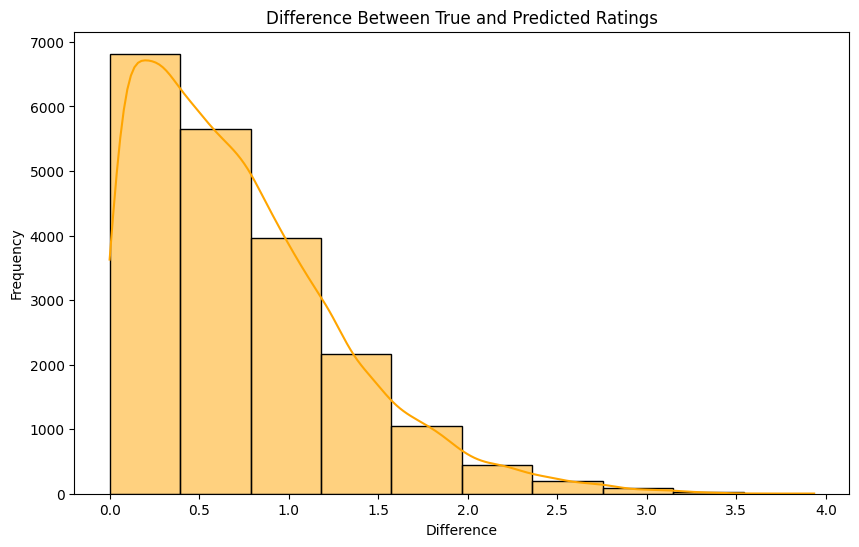

In [40]:
# Check the first few rows of the predictions table
print(predictions_df.head())

# Calculate how many predictions are within 1 point of the true rating
predictions_df['diff'] = abs(predictions_df['true_rating'] - predictions_df['est'])
predictions_within_1 = predictions_df[predictions_df['diff'] <= 1]
print(f"Predictions within 1 point of true ratings: {len(predictions_within_1)}")

# Visualize the differences between the true ratings and the predictions
plt.figure(figsize=(10, 6))
sns.histplot(predictions_df['diff'], kde=True, bins=10, color='orange')
plt.title("Difference Between True and Predicted Ratings")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show()

Compare Gender-Based Results


RMSE for male users: 0.9139
RMSE for female users: 0.9699


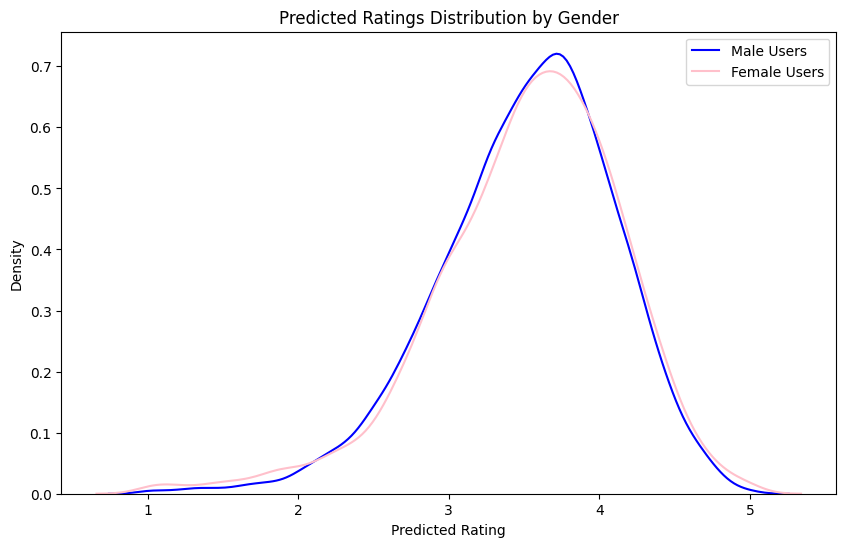

In [41]:
# Ensure there are no duplicates in the gender comparison dataframe
df_gender_comparison = df_full[['user_id', 'gender']].drop_duplicates()

# Merge gender information with predictions dataframe (this will now not explode the rows)
predictions_df = pd.merge(predictions_df, df_gender_comparison, on='user_id', how='inner')

# Calculate RMSE for male and female users separately
male_predictions = predictions_df[predictions_df['gender'] == 'M']
female_predictions = predictions_df[predictions_df['gender'] == 'F']

male_rmse = (male_predictions['true_rating'] - male_predictions['est']).apply(lambda x: x**2).mean() ** 0.5
female_rmse = (female_predictions['true_rating'] - female_predictions['est']).apply(lambda x: x**2).mean() ** 0.5

print(f"RMSE for male users: {male_rmse:.4f}")
print(f"RMSE for female users: {female_rmse:.4f}")

# Optionally, compare predicted ratings distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(male_predictions['est'], label='Male Users', color='blue')
sns.kdeplot(female_predictions['est'], label='Female Users', color='pink')
plt.title("Predicted Ratings Distribution by Gender")
plt.xlabel("Predicted Rating")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
# Create an empty list to collect prediction rows for SVD++
svdpp_preds = []

# Loop through the test set and collect predictions
for _, row in test_long.iterrows():  # Use 'test_long' instead of 'df_test'
    user = row['userid']  # Ensure 'userid' is the correct column name in test_long
    movie = row['movieid']  # Ensure 'movieid' is the correct column name in test_long
    actual = row['rating']
    
    # Predict the rating using the SVD++ model (assuming you have a predict method)
    pred = best_model.predict(user, movie).est  # Using the trained SVD++ model
    
    # Only add valid predictions (non-NaN predictions)
    if not np.isnan(pred):
        svdpp_preds.append({
            'user_id': user,
            'movie_id': movie,
            'actual_rating': actual,
            'predicted_rating': pred,
            'model': 'svdpp'
        })

# Convert to DataFrame
df_svdpp_preds = pd.DataFrame(svdpp_preds)

# Quick check
print(df_svdpp_preds.head())
print(f"\nTotal predictions made by SVD++: {len(df_svdpp_preds)}")

# saved and used for fairness metrics

   user_id  movie_id  actual_rating  predicted_rating  model
0      1.0       9.0            5.0          4.170055  svdpp
1      1.0      14.0            5.0          4.031778  svdpp
2      1.0      15.0            5.0          3.535803  svdpp
3      1.0      18.0            4.0          3.177638  svdpp
4      1.0      21.0            1.0          2.633489  svdpp

Total predictions made by SVD++: 20381
